<a href="https://colab.research.google.com/github/QiuYue24/CASA0006_assessment/blob/main/Template_submission_CASA0006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Title]

## Preparation

- [Github link](https://github.com/QiuYue24/CASA0006_assessment.git)

- Number of words: 1459

- Runtime: *** hours (*Memory 10 GB, CPU Intel i7-10700 CPU @2.20GHz*)

- Coding environment: Google Colab

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/)

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Childhood obesity has become a growing public health problem, and there is growing evidence that socioeconomic and environmental factors play a crucial role in its spatial distribution. Building on recent research using spatial modelling techniques to analyse the impact of the social environment on health outcomes (Chalkias et al., 2013; Sun et al., 2020), this study wanted to explore the relationship between the prevalence of childhood obesity and socio-environmental characteristics in London boroughs, which can be utilised using Geographic Information System (GIS) data. In addition to environmental factors, socio-economic factors have also been associated with the prevalence of childhood obesity (Sun et al., 2020), and the present study refers to a similar methodology used in spatial studies related to obesity (Jia et al., 2017) in order to incorporate factors such as deprivation, ethnicity, availability of green space and fast food density. The main model used in this paper, Ordinary Least Squares (OLS) models, which are widely used to test associations between variables, inform targeted local interventions to prevent childhood obesity by identifying key socio-economic as well as environmental determinants.

## Research questions

[[ go back to the top ]](#Table-of-contents)

What socio-economic and environmental factors significantly influence the prevalence of childhood obesity among Year 6 students in London boroughs, and how can their impacts be quantified through statistical modeling?

## Data

[[ go back to the top ]](#Table-of-contents)

In [3]:
# Install Necessary Packages
!pip install pandas numpy geopandas matplotlib seaborn scipy statsmodels scikit-learn esda libpysal splot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 25.0 MB/s eta 0:00:00


In [4]:
# Basic packages
import pandas as pd
import numpy as np
import os
import warnings

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# Linear regression analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Ridge regression and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV

# Random Forest and machine learning utilities
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Spatial autocorrelation analysis
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
from splot.esda import moran_scatterplot


In [5]:
import time
start_time = time.time()

### Presentation of Data and Data preprocessing

In this study, official data on childhood obesity rates in London boroughs was utilized, focusing on Year 6 students as the target group. Based on existing literature, 3 socio-economic factors and 3 environmental factors were selected for analysis, with 2019 as the primary year of focus. The dependent and independent variables, along with their data sources, are summarized in Table 1.

Table 1 that describes the selected variables

| Variable | Type | Description | Notes | Data Source |
|:---|:---|:---|:---|:---|
| Year6_Obesity_Prevalence_2018-19 | Numeric | Childhood obesity prevalence (%) for Year 6 students in 2018-19 | Dependent variable | [Department of Health](https://data.london.gov.uk/dataset/prevalence-childhood-obesity-borough) |
| IMD_Avg_Score | Numeric | Average deprivation score based on IMD | Independent variable (socio-economic factor) | [Indices of Deprivation](https://data.london.gov.uk/dataset/indices-of-deprivation) |
| non_working_proportion | Numeric | Proportion of households with no working adults with dependent children | Independent variable (socio-economic factor) | [Nomis](https://www.nomisweb.co.uk/query/construct/summary.asp?reset=yes&mode=construct&dataset=136&version=0&anal=1) |
| non_white_proportion | Numeric | Proportion of non-white population in each borough | Independent variable (socio-economic factor) | [Census 2021](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationandhouseholdestimatesenglandandwalescensus2021) |
| Fast_Food_Density | Numeric | Fast food outlet density per km² in each borough | Independent variable (environmental factor) | [Geofabrik UK (OpenStreetMap shapefile)](https://download.geofabrik.de/europe/united-kingdom/england/greater-london.html) |
| percent_green | Numeric | Percentage of green land cover within each borough | Independent variable (environmental factor) | [London Green and Blue Cover](https://data.london.gov.uk/dataset/green-and-blue-cover) |
| population_density_ha | Numeric | Population density per hectare | Independent variable (environmental factor) | [ONS Population Estimates](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/estimatesofthepopulationforenglandandwales) |


Firstly a brief look at the main datasets used for childhood obesity rates.

In [6]:
file_path = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/childhood-obesity-borough.xlsx'
year = '2018-19'

# Column name mapping
df_year = pd.read_excel(file_path, sheet_name=year, header=2)
df_year.head()

,ONS Code,Area,Prevalence (%),lower confidence interval,upper confidence interval,Prevalence (%).1,lower confidence interval.1,upper confidence interval.1,Prevalence (%).2,lower confidence interval.2,...,lower confidence interval.7,upper confidence interval.7,Prevalence (%).8,lower confidence interval.8,upper confidence interval.8,Prevalence (%).9,lower confidence interval.9,upper confidence interval.9,Reception,Year 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,1.774970,1.378583,2.282693,1.304726,0.976543,1.741261,73.194946,71.663005,...,27.960003,31.001333,4.452467,3.802302,5.207786,8.031313,7.170293,8.985718,3324.0,3449.0
2,E09000003,Barnet,1.712329,1.357590,2.157733,1.289852,0.987511,1.683184,79.207436,77.936271,...,18.833741,21.280653,1.883562,1.509758,2.347709,4.404965,3.818965,5.076138,4088.0,4109.0
3,E09000004,Bexley,0.708741,0.464034,1.081093,1.074929,0.770254,1.498298,76.712791,75.156935,...,21.551562,24.482996,2.902464,2.356304,3.570587,5.216567,4.494537,6.047243,2963.0,3163.0
4,E09000005,Brent,2.559775,2.089586,3.132380,2.087852,1.673814,2.601599,71.476793,69.969971,...,24.613034,27.443412,3.881857,3.295064,4.568210,6.046638,5.322167,6.862578,3555.0,3688.0


Although the table layout is rather confusing, it is known that we selected data on childhood obesity rates at borough level within the London borough, so preprocessing of childhood obesity rate data was carried out based on the original files.

In [7]:

print("="*50)
print("1. Processing Childhood Obesity Data")
print("="*50)

column_mapping = {
    "Prevalence_(%)": "Reception_Underweight_Prevalence",
    "lower_confidence_interval": "Reception_Underweight_LCI",
    "upper_confidence_interval": "Reception_Underweight_UCI",
    "Prevalence_(%).1": "Year6_Underweight_Prevalence",
    "lower_confidence_interval.1": "Year6_Underweight_LCI",
    "upper_confidence_interval.1": "Year6_Underweight_UCI",
    "Prevalence_(%).2": "Reception_HealthyWeight_Prevalence",
    "lower_confidence_interval.2": "Reception_HealthyWeight_LCI",
    "upper_confidence_interval.2": "Reception_HealthyWeight_UCI",
    "Prevalence_(%).3": "Year6_HealthyWeight_Prevalence",
    "lower_confidence_interval.3": "Year6_HealthyWeight_LCI",
    "upper_confidence_interval.3": "Year6_HealthyWeight_UCI",
    "Prevalence_(%).4": "Reception_Overweight_Prevalence",
    "lower_confidence_interval.4": "Reception_Overweight_LCI",
    "upper_confidence_interval.4": "Reception_Overweight_UCI",
    "Prevalence_(%).5": "Year6_Overweight_Prevalence",
    "lower_confidence_interval.5": "Year6_Overweight_LCI",
    "upper_confidence_interval.5": "Year6_Overweight_UCI",
    "Prevalence_(%).6": "Reception_Obesity_Prevalence",
    "lower_confidence_interval.6": "Reception_Obesity_LCI",
    "upper_confidence_interval.6": "Reception_Obesity_UCI",
    "Prevalence_(%).7": "Year6_Obesity_Prevalence",
    "lower_confidence_interval.7": "Year6_Obesity_LCI",
    "upper_confidence_interval.7": "Year6_Obesity_UCI",
    "Prevalence_(%).8": "Reception_SevereObesity_Prevalence",
    "lower_confidence_interval.8": "Reception_SevereObesity_LCI",
    "upper_confidence_interval.8": "Reception_SevereObesity_UCI",
    "Prevalence_(%).9": "Year6_SevereObesity_Prevalence",
    "lower_confidence_interval.9": "Year6_SevereObesity_LCI",
    "upper_confidence_interval.9": "Year6_SevereObesity_UCI",
    "Reception": "Reception_SampleSize",
    "Year_6": "Year6_SampleSize"
}

# Clean column names
df_year.columns = df_year.columns.str.strip()
df_year.columns = df_year.columns.str.replace(r'\s+', '_', regex=True)

# Standardize ONS_Code and Area fields
df_year['ONS_Code'] = df_year['ONS_Code'].str.strip()
df_year['Area'] = df_year['Area'].str.strip()

# Rename columns
df_year.rename(columns={
    col: f"{column_mapping.get(col, col)}_{year}" if col not in ['ONS_Code', 'Area'] else col
    for col in df_year.columns
}, inplace=True)

df_year.sort_values(by='ONS_Code', inplace=True)

# Convert relevant columns to numeric
to_numeric_cols = [
    col for col in df_year.columns
    if "Prevalence" in col or "SampleSize" in col
]
for col in to_numeric_cols:
    df_year[col] = pd.to_numeric(df_year[col], errors='coerce')

# Keep only the Year6 Obesity Prevalence data
columns_to_keep = ["ONS_Code", "Area", "Year6_Obesity_Prevalence_2018-19"]
obesity_data = df_year[columns_to_keep]

print("Preview of Obesity Data:")
print(f"Data shape: {obesity_data.shape}")
print(f"Columns: {obesity_data.columns.tolist()}")

1. Processing Childhood Obesity Data
Preview of Obesity Data:
Data shape: (45, 3)
Columns: ['ONS_Code', 'Area', 'Year6_Obesity_Prevalence_2018-19']


View pre-processed data on childhood obesity rates

In [8]:
print(obesity_data.head())
print(f"\nNumber of unique area codes: {obesity_data['ONS_Code'].nunique()}")
print(f"Number of unique area names: {obesity_data['Area'].nunique()}")

    ONS_Code                  Area  Year6_Obesity_Prevalence_2018-19
1  E09000002  Barking and Dagenham                         29.457814
2  E09000003                Barnet                         20.029204
3  E09000004                Bexley                         22.984508
4  E09000005                 Brent                         26.003254
5  E09000006               Bromley                         17.807457

Number of unique area codes: 42
Number of unique area names: 42


Borough Boundary and Fast Food Restaurant Density Data Processing

In [9]:
print("\n" + "="*50)
print("2. Processing Borough Boundaries and Fast Food Outlet Density Data")
print("="*50)

# Load borough boundary data
borough_url = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/London_Boroughs.geojson'
boroughs = gpd.read_file(borough_url)
boroughs = boroughs[boroughs['gss_code'] != 'E09000001']  # Exclude City of London
print(f"Shape of borough boundary data: {boroughs.shape}")
print(f"Columns in borough boundary data: {boroughs.columns.tolist()}")

# Load fast food outlet data
fast_food = gpd.read_file("https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/possessed_data/london_fast_food_clipped.geojson")
print(f"\nShape of fast food outlet data: {fast_food.shape}")

# Standardize coordinate reference systems
boroughs = boroughs.to_crs(epsg=27700)
fast_food = fast_food.to_crs(epsg=27700)

# Spatial join
joined = gpd.sjoin(fast_food, boroughs, how="inner", predicate="intersects")
fast_counts = joined.groupby("gss_code")["osm_id"].count().reset_index()
fast_counts.columns = ["gss_code", "Fast_Food_Count"]

# Calculate area and density
boroughs["area_km2"] = boroughs.geometry.area / 1e6
merged_fastfood = boroughs.merge(fast_counts, on="gss_code", how="left")
merged_fastfood["Fast_Food_Count"] = merged_fastfood["Fast_Food_Count"].fillna(0)
merged_fastfood['name'] = merged_fastfood['name'].str.strip()
merged_fastfood["Fast_Food_Density"] = merged_fastfood["Fast_Food_Count"] / merged_fastfood["area_km2"]

fastfood_data = merged_fastfood[["gss_code", "name", "Fast_Food_Count", "area_km2", "Fast_Food_Density"]]
print(f"Shape of fast food density data: {fastfood_data.shape}")


2. Processing Borough Boundaries and Fast Food Outlet Density Data
Shape of borough boundary data: (32, 8)
Columns in borough boundary data: ['objectid', 'name', 'gss_code', 'hectares', 'nonld_area', 'ons_inner', 'sub_2011', 'geometry']

Shape of fast food outlet data: (4130, 268)
Shape of fast food density data: (32, 5)


In [10]:
print(fastfood_data.head())
print(f"\nNumber of unique GSS codes: {fastfood_data['gss_code'].nunique()}")
print(f"Range of fast food outlet density: {fastfood_data['Fast_Food_Density'].min():.2f} - {fastfood_data['Fast_Food_Density'].max():.2f}")

    gss_code                  name  Fast_Food_Count    area_km2  \
0  E09000021  Kingston upon Thames               54   37.261178   
1  E09000008               Croydon              188   86.494436   
2  E09000006               Bromley               98  150.134858   
3  E09000018              Hounslow               97   56.585441   
4  E09000009                Ealing              140   55.544352   

   Fast_Food_Density  
0           1.449230  
1           2.173550  
2           0.652746  
3           1.714222  
4           2.520508  

Number of unique GSS codes: 32
Range of fast food outlet density: 0.30 - 15.52


Data processing for IMD aggregate indicators (only mean scores are retained)

In [11]:
print("\n" + "="*50)
print("3. Processing Overall IMD Data (Keeping Only Average Score)")
print("="*50)

imd_file = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/imd_borough_summary.xlsx'
imd_df = pd.read_excel(imd_file, sheet_name="Borough summary measures")
imd_df.columns = imd_df.columns.str.strip()

# Select only the IMD average score
imd_data = imd_df[[
    'Local Authority District code (2019)',
    'IMD - Average score'
]]

# Rename columns
imd_data.columns = ["gss_code", "IMD_Avg_Score"]

print("Preview of IMD data (Average Score only):")
print(f"Data shape: {imd_data.shape}")
print(imd_data.head())
print(f"\nNumber of unique GSS codes: {imd_data['gss_code'].nunique()}")
print(f"Range of IMD average scores: {imd_data['IMD_Avg_Score'].min():.2f} - {imd_data['IMD_Avg_Score'].max():.2f}")



3. Processing Overall IMD Data (Keeping Only Average Score)
Preview of IMD data (Average Score only):
Data shape: (33, 2)
    gss_code  IMD_Avg_Score
0  E09000001         14.720
1  E09000002         32.768
2  E09000003         16.148
3  E09000004         16.273
4  E09000005         25.558

Number of unique GSS codes: 33
Range of IMD average scores: 9.43 - 32.77


Greenfield coverage data processing (greenfield only)

In [12]:
print("\n" + "="*50)
print("4. Processing Green Space Coverage Data (Green Areas Only)")
print("="*50)

green_file = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/green_cover_borough_summary_0.05.xlsx'
green_statistics = pd.read_excel(green_file, sheet_name="borough_green_cover")
green_statistics.columns = green_statistics.columns.str.strip()

# Extract only the percentage of green space
green_data = green_statistics[["lb_name", "percent_green"]]
green_data = green_data.rename(columns={"lb_name": "borough"})

print("Preview of Green Space Coverage Data:")
print(f"Data shape: {green_data.shape}")
print(green_data.head())
print(f"\nNumber of unique borough names: {green_data['borough'].nunique()}")
print(f"Range of green space coverage: {green_data['percent_green'].min():.2f}% - {green_data['percent_green'].max():.2f}%")


4. Processing Green Space Coverage Data (Green Areas Only)
Preview of Green Space Coverage Data:
Data shape: (33, 2)
     borough  percent_green
0  E09000001       5.590892
1  E09000002      39.201168
2  E09000003      57.994299
3  E09000004      42.918334
4  E09000005      39.936406

Number of unique borough names: 33
Range of green space coverage: 5.59% - 68.36%


Population density data processing

In [13]:
print("\n" + "="*50)
print("5. Processing Population Density Data")
print("="*50)

density_file = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/cencus/sape23dt11mid2020lsoapopulationdensity.xlsx'
density_df = pd.read_excel(density_file, sheet_name="Mid-2020 Population Density")

# Rename columns
density_df.columns = ['lsoa_code', 'lsoa_name', 'population', 'area_km2', 'pop_density_km2']

# Convert data types
density_df['population'] = pd.to_numeric(density_df['population'], errors='coerce')
density_df['area_km2'] = pd.to_numeric(density_df['area_km2'], errors='coerce')

# Extract borough name
density_df['borough_name'] = density_df['lsoa_name'].str.extract(r'^(.*) \d{3}[A-Z]')

# List of 32 London boroughs
london_boroughs = [
    "Barking and Dagenham", "Barnet", "Bexley", "Brent", "Bromley", "Camden",
    "Croydon", "Ealing", "Enfield", "Greenwich", "Hackney", "Hammersmith and Fulham", "Haringey",
    "Harrow", "Havering", "Hillingdon", "Hounslow", "Islington", "Kensington and Chelsea", "Kingston upon Thames",
    "Lambeth", "Lewisham", "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Southwark",
    "Sutton", "Tower Hamlets", "Waltham Forest", "Wandsworth", "Westminster"
]
density_df = density_df[density_df['borough_name'].isin(london_boroughs)].copy()

# Aggregate total population and area per borough
borough_summary = density_df.groupby('borough_name').agg({
    'population': 'sum',
    'area_km2': 'sum'
}).reset_index()

# Calculate population density per hectare
borough_summary['population_density_ha'] = (borough_summary['population'] / (borough_summary['area_km2'] * 100)).round(0).astype(int)
density_data = borough_summary[['borough_name', 'population_density_ha']]

print("Preview of Population Density Data:")
print(f"Data shape: {density_data.shape}")
print(density_data.head())
print(f"\nNumber of unique borough names: {density_data['borough_name'].nunique()}")
print(f"Range of population density per hectare: {density_data['population_density_ha'].min()} - {density_data['population_density_ha'].max()} persons/ha")


5. Processing Population Density Data
Preview of Population Density Data:
Data shape: (32, 2)
           borough_name  population_density_ha
0  Barking and Dagenham                     59
1                Barnet                     46
2                Bexley                     41
3                 Brent                     76
4               Bromley                     22

Number of unique borough names: 32
Range of population density per hectare: 22 - 168 persons/ha


Data processing of the proportion of workless families with dependent children

In [14]:
warnings.filterwarnings('ignore')
print("\n" + "="*50)
print("6. Data processing of the proportion of workless families with dependent children")
print("="*50)

# Read Excel file
workless_file = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/wugongzuo/nomis_120404.xlsx'
df_workless = pd.read_excel(workless_file, skiprows=7)

# Rename columns
df_workless.columns = ['District', 'Code', 'All_Households', 'All_Flags',
                       'Working_Households', 'Working_Flags', 'Workless_Households', 'Workless_Flags']

# Clean data - remove empty rows and total summary rows
df_workless = df_workless.dropna(subset=['District'])
df_workless = df_workless[df_workless['District'] != 'Column Total']

# Calculate non-working households
df_workless['Non_Working_Households'] = df_workless['All_Households'] - df_workless['Working_Households']

# Calculate proportion of non-working households
df_workless['Non_Working_Proportion'] = (df_workless['Non_Working_Households'] / df_workless['All_Households']) * 100

# Select necessary columns
workless_data = df_workless[['District', 'Code', 'Non_Working_Proportion']]
workless_data.columns = ['borough_name', 'gss_code', 'non_working_proportion']

print("Preview of Workless Household Proportion Data:")
print(f"Data shape: {workless_data.shape}")
print(workless_data.head())
print(f"\nNumber of unique borough names: {workless_data['borough_name'].nunique()}")
print(f"Range of non-working household proportion: {workless_data['non_working_proportion'].min():.1f}% - {workless_data['non_working_proportion'].max():.1f}%")


6. Data processing of the proportion of workless families with dependent children
Preview of Workless Household Proportion Data:
Data shape: (34, 3)
           borough_name   gss_code  non_working_proportion
0  Barking and Dagenham  E09000002               53.260870
1                Barnet  E09000003               57.359813
2                Bexley  E09000004               55.610561
3                 Brent  E09000005               59.895151
4               Bromley  E09000006               41.860465

Number of unique borough names: 34
Range of non-working household proportion: 36.9% - 70.6%


Processing of data on the proportion of non-whites

In [15]:
print("\n" + "="*50)
print("7. Processing Non-White Population Proportion Data")
print("="*50)

# Read Excel file
ethnicity_file = 'https://raw.githubusercontent.com/QiuYue24/CASA0006_assessment/main/data/feibairen/nomis_114610.xlsx'
df_ethnicity = pd.read_excel(ethnicity_file, skiprows=8)

# Rename columns
df_ethnicity.columns = ['District', 'Code', 'Total_Persons', 'Total_Percent', 'White_Persons', 'White_Percent']

# Clean data - remove empty rows and total summary rows
df_ethnicity = df_ethnicity.dropna(subset=['District'])

# Calculate non-white proportion
df_ethnicity['Non_White_Proportion'] = 100 - df_ethnicity['White_Percent']

# Select required columns
ethnicity_data = df_ethnicity[['District', 'Code', 'Non_White_Proportion']].copy()
ethnicity_data.columns = ['borough_name', 'gss_code', 'non_white_proportion']

# Round to one decimal place
ethnicity_data.loc[:, 'non_white_proportion'] = ethnicity_data['non_white_proportion'].round(1)

print("Preview of Non-White Population Proportion Data:")
print(f"Data shape: {ethnicity_data.shape}")
print(ethnicity_data.head())
print(f"\nNumber of unique borough names: {ethnicity_data['borough_name'].nunique()}")
print(f"Range of non-white population proportion: {ethnicity_data['non_white_proportion'].min():.1f}% - {ethnicity_data['non_white_proportion'].max():.1f}%")


7. Processing Non-White Population Proportion Data
Preview of Non-White Population Proportion Data:
Data shape: (33, 3)
           borough_name   gss_code  non_white_proportion
0  Barking and Dagenham  E09000002                  55.1
1                Barnet  E09000003                  42.3
2                Bexley  E09000004                  28.1
3                 Brent  E09000005                  65.4
4               Bromley  E09000006                  23.5

Number of unique borough names: 33
Range of non-white population proportion: 19.5% - 69.2%


Create a code and name mapping table for subsequent matching and merging of data

In [16]:
print("\n" + "="*50)
print("8. Creating Borough Code-Name Mapping Table")
print("="*50)

# Extract gss_code and name mapping from fastfood_data
code_name_mapping = fastfood_data[['gss_code', 'name']].drop_duplicates()
print(f"GSS Code - Borough Name Mapping Table:")
print(f"Data shape: {code_name_mapping.shape}")
print(code_name_mapping.head(10))


8. Creating Borough Code-Name Mapping Table
GSS Code - Borough Name Mapping Table:
Data shape: (32, 2)
    gss_code                  name
0  E09000021  Kingston upon Thames
1  E09000008               Croydon
2  E09000006               Bromley
3  E09000018              Hounslow
4  E09000009                Ealing
5  E09000016              Havering
6  E09000017            Hillingdon
7  E09000015                Harrow
8  E09000005                 Brent
9  E09000003                Barnet


Final data integration

In [17]:
# Create the base dataframe using code_name_mapping
final_data = code_name_mapping.copy()

# Exclude the record with GSS code E09000001 (City of London)
final_data = final_data[final_data['gss_code'] != 'E09000001']

# Merge obesity prevalence data
obesity_data_renamed = obesity_data.rename(columns={'ONS_Code': 'gss_code'})
final_data = final_data.merge(
    obesity_data_renamed.drop('Area', axis=1),
    on='gss_code',
    how='left'
)

# Merge fast food outlet density data
final_data = final_data.merge(
    fastfood_data[['gss_code', 'Fast_Food_Density']],
    on='gss_code',
    how='left'
)

# Merge IMD average score data
final_data = final_data.merge(
    imd_data,
    on='gss_code',
    how='left'
)

# Merge green space coverage data
final_data = final_data.merge(
    green_data.rename(columns={'borough': 'gss_code'}),
    on='gss_code',
    how='left'
)

# Merge population density data
final_data = final_data.merge(
    density_data.rename(columns={'borough_name': 'name'}),
    on='name',
    how='left'
)

# Merge non-working household proportion data
final_data = final_data.merge(
    workless_data[['gss_code', 'non_working_proportion']],
    on='gss_code',
    how='left'
)

# Merge non-white population proportion data
final_data = final_data.merge(
    ethnicity_data[['gss_code', 'non_white_proportion']],
    on='gss_code',
    how='left'
)

Check the final data

In [18]:
print("\nPreview of Final Integrated Dataset:")
print(f"Data shape: {final_data.shape}")
print(f"Column names: {final_data.columns.tolist()}")

final_data


Preview of Final Integrated Dataset:
Data shape: (32, 9)
Column names: ['gss_code', 'name', 'Year6_Obesity_Prevalence_2018-19', 'Fast_Food_Density', 'IMD_Avg_Score', 'percent_green', 'population_density_ha', 'non_working_proportion', 'non_white_proportion']


,gss_code,name,Year6_Obesity_Prevalence_2018-19,Fast_Food_Density,IMD_Avg_Score,percent_green,population_density_ha,non_working_proportion,non_white_proportion
0,E09000021,Kingston upon Thames,14.239829,1.449230,11.381,52.424867,48,40.486726,31.7
1,E09000008,Croydon,24.523973,2.173550,22.477,55.527790,45,51.419558,51.6
2,E09000006,Bromley,17.807457,0.652746,14.163,68.356138,22,41.860465,23.5
3,E09000018,Hounslow,24.811558,1.714222,21.487,47.313020,49,70.084034,55.9
4,E09000009,Ealing,24.409449,2.520508,22.710,43.958704,61,69.247546,56.8
5,E09000016,Havering,21.467391,0.297054,16.789,65.980651,23,45.768566,24.7
6,E09000017,Hillingdon,23.589609,0.864300,18.223,54.596097,27,53.670886,51.8
7,E09000015,Harrow,20.048226,2.159985,15.031,55.418726,50,60.512821,63.5
8,E09000005,Brent,26.003254,2.220544,25.558,39.936406,76,59.895151,65.4
9,E09000003,Barnet,20.029204,1.314147,16.148,57.994299,46,57.359813,42.3


Checking for missing values

In [19]:
print("\nMissing value cases：")
print(final_data.isnull().sum())


Missing value cases：
gss_code                            0
name                                0
Year6_Obesity_Prevalence_2018-19    0
Fast_Food_Density                   0
IMD_Avg_Score                       0
percent_green                       0
population_density_ha               0
non_working_proportion              0
non_white_proportion                0
dtype: int64


Generate data summaries

In [20]:
print("\n" + "="*50)
print("Data Summary")
print("="*50)
print(f"Total number of records: {len(final_data)}")
print(f"Total number of features: {len(final_data.columns)}")
print("\nSummary statistics for each feature:")
print(final_data.describe())


Data Summary
Total number of records: 32
Total number of features: 9

Summary statistics for each feature:
       Year6_Obesity_Prevalence_2018-19  Fast_Food_Density  IMD_Avg_Score  \
count                         32.000000          32.000000      32.000000   
mean                          22.706491           3.926039      21.500125   
std                            3.747953           3.658668       6.052737   
min                           11.215792           0.297054       9.425000   
25%                           20.393706           1.415459      16.526500   
50%                           23.540593           2.370526      21.898000   
75%                           24.667661           5.947209      25.788500   
max                           29.457814          15.524246      32.768000   

       percent_green  population_density_ha  non_working_proportion  \
count      32.000000              32.000000               32.000000   
mean       44.802959              77.812500             

## Methodology

[[ go back to the top ]](#Table-of-contents)

*[Note: a flow chart that describes the methodology is strongly encouraged - see the example below. This flow chart can be made using Microsoft powerpoint or visio or other software]*

Source: see [link](https://linkinghub.elsevier.com/retrieve/pii/S2210670722004437).

![image.png](attachment:image.png)

Based on extensive previous research, socio-economic status (SES) and built environment characteristics have been identified as key determinants of childhood obesity. After testing a range of socio-economic and environmental variables, six explanatory variables and one outcome variable were selected for analysis. Accordingly, multiple linear regression was used as the primary analytical method, supplemented by Ridge regression and Random Forest to ensure robustness.

First look at the contents of the merged data

In [21]:
final_data.head()

,gss_code,name,Year6_Obesity_Prevalence_2018-19,Fast_Food_Density,IMD_Avg_Score,percent_green,population_density_ha,non_working_proportion,non_white_proportion
0,E09000021,Kingston upon Thames,14.239829,1.449230,11.381,52.424867,48,40.486726,31.7
1,E09000008,Croydon,24.523973,2.173550,22.477,55.527790,45,51.419558,51.6
2,E09000006,Bromley,17.807457,0.652746,14.163,68.356138,22,41.860465,23.5
3,E09000018,Hounslow,24.811558,1.714222,21.487,47.313020,49,70.084034,55.9
4,E09000009,Ealing,24.409449,2.520508,22.710,43.958704,61,69.247546,56.8


In [22]:
boroughs.head()

,objectid,name,gss_code,hectares,nonld_area,ons_inner,sub_2011,geometry,area_km2
0,1,Kingston upon Thames,E09000021,3726.117,0.000,F,South,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",37.261178
1,2,Croydon,E09000008,8649.441,0.000,F,South,"POLYGON ((535009.2 159504.7, 535005.5 159502, ...",86.494436
2,3,Bromley,E09000006,15013.487,0.000,F,South,"POLYGON ((540373.6 157530.4, 540361.2 157551.9...",150.134858
3,4,Hounslow,E09000018,5658.541,60.755,F,West,"POLYGON ((509703.4 175356.6, 509712.6 175361.8...",56.585441
4,5,Ealing,E09000009,5554.428,0.000,F,West,"POLYGON ((515647.2 178787.8, 515608.8 178787.3...",55.544352


### Spatial autocorrelation analysis (Moran's I)

Spatial aggregation may be an important contextual factor in analysing obesity rates, firstly values of Moran's I were calculated and scatter plots were made

In [23]:
warnings.filterwarnings('ignore')

# Create output directory
if not os.path.exists('outputs'):
    os.makedirs('outputs')

plt.rcParams['axes.unicode_minus'] = False

# Merge spatial boundary data with analytical dataset
spatial_data = boroughs.merge(final_data, on='gss_code', how='left')

# Preview merged data
print("\nData Preview:")
print(f"Shape of spatial data: {spatial_data.shape}")
print("\nNumber of boroughs with available obesity data:", spatial_data['Year6_Obesity_Prevalence_2018-19'].count())
print("\nDescriptive statistics for Year 6 Obesity Prevalence:")
print(spatial_data['Year6_Obesity_Prevalence_2018-19'].describe())


Data Preview:
Shape of spatial data: (32, 17)

Number of boroughs with available obesity data: 32

Descriptive statistics for Year 6 Obesity Prevalence:
count    32.000000
mean     22.706491
std       3.747953
min      11.215792
25%      20.393706
50%      23.540593
75%      24.667661
max      29.457814
Name: Year6_Obesity_Prevalence_2018-19, dtype: float64


Creating a spatial weight matrix

In [24]:
w = Queen.from_dataframe(spatial_data, use_index=True)

print(f"\nCharacteristics of the spatial weights matrix:")
print(f"Matrix dimensions: {w.n} x {w.n}")
print(f"Average number of neighbors: {w.mean_neighbors:.2f}")
print(f"Maximum number of neighbors: {w.max_neighbors}")
print(f"Minimum number of neighbors: {w.min_neighbors}")


Characteristics of the spatial weights matrix:
Matrix dimensions: 32 x 32
Average number of neighbors: 4.69
Maximum number of neighbors: 7
Minimum number of neighbors: 3


Calculate Moran's I

In [25]:
y = spatial_data['Year6_Obesity_Prevalence_2018-19'].values
moran = Moran(y, w)

Print results

In [26]:
print("\n\nMoran's I Statistics:")
print(f"Moran's I value: {moran.I:.4f}")
print(f"Expected value: {moran.EI:.4f}")
print(f"z-score: {moran.z_sim:.4f}")
print(f"p-value: {moran.p_sim:.4f}")

if moran.p_sim < 0.01:
    print("\nConclusion: Highly significant spatial autocorrelation (p < 0.01)")
elif moran.p_sim < 0.05:
    print("\nConclusion: Significant spatial autocorrelation (p < 0.05)")
else:
    print("\nConclusion: No significant spatial autocorrelation")



Moran's I Statistics:
Moran's I value: 0.2981
Expected value: -0.0323
z-score: 3.2591
p-value: 0.0020

Conclusion: Highly significant spatial autocorrelation (p < 0.01)


Visualising Moran Scatterplots

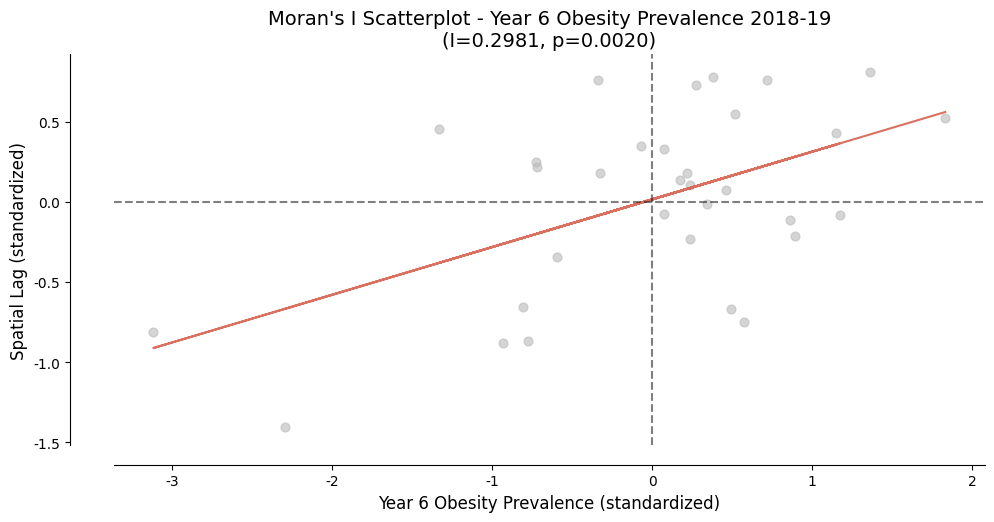

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
moran_scatterplot(moran, ax=ax)
plt.title(f"Moran's I Scatterplot - Year 6 Obesity Prevalence 2018-19\n(I={moran.I:.4f}, p={moran.p_sim:.4f})", fontsize=14)
plt.xlabel('Year 6 Obesity Prevalence (standardized)', fontsize=12)
plt.ylabel('Spatial Lag (standardized)', fontsize=12)
plt.tight_layout()

if os.path.exists('outputs'):
    plt.savefig('outputs/moran_scatterplot.png', dpi=300, bbox_inches='tight')
plt.show()

This suggests that there is a clustering of childhood obesity rates at the borough level.

Visualised map of spatial distribution of childhood obesity rates is more intuitive.

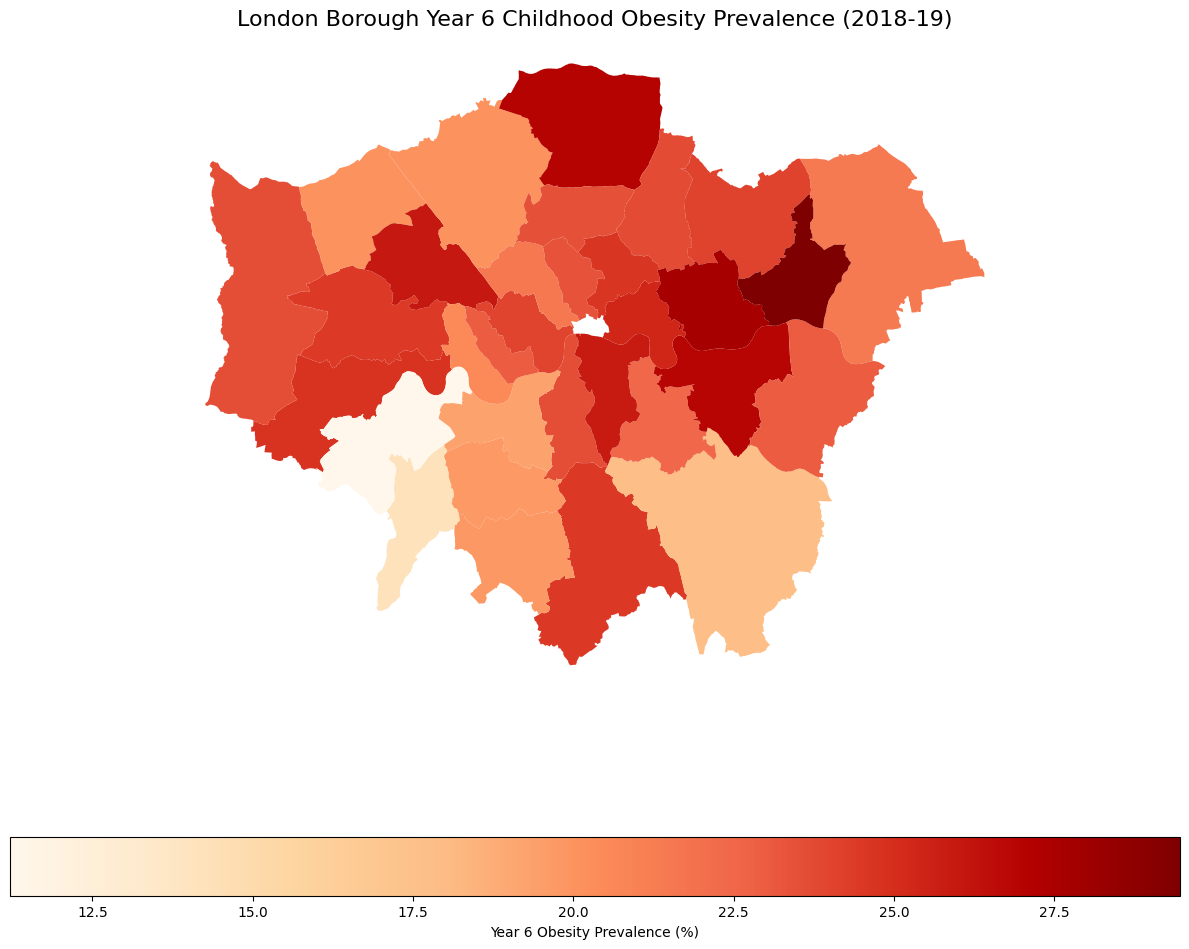

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
spatial_data.plot(column='Year6_Obesity_Prevalence_2018-19',
                  cmap='OrRd',
                  legend=True,
                  ax=ax,
                  legend_kwds={'label': "Year 6 Obesity Prevalence (%)", 'orientation': "horizontal"})
ax.set_title('London Borough Year 6 Childhood Obesity Prevalence (2018-19)', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
if os.path.exists('outputs'):
    plt.savefig('outputs/obesity_spatial_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Multiple linear regression (OLS)

Before carrying out multiple linear regression analysis, we should first consider the multicollinearity between independent variables. Firstly, let's check the data basics first.

Make sure there are no variables of non-numeric types, check with final_data.info().

In [29]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gss_code                          32 non-null     object 
 1   name                              32 non-null     object 
 2   Year6_Obesity_Prevalence_2018-19  32 non-null     float64
 3   Fast_Food_Density                 32 non-null     float64
 4   IMD_Avg_Score                     32 non-null     float64
 5   percent_green                     32 non-null     float64
 6   population_density_ha             32 non-null     int64  
 7   non_working_proportion            32 non-null     float64
 8   non_white_proportion              32 non-null     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.4+ KB


We can see that the ‘gss_code’ and ‘name’ columns are formatted as objects, while the rest of the columns are formatted as floats and integers. This indicates that we do not need to change the data format of the independent and dependent variables.

Prepare data, select independent and dependent variables.

In [30]:
X_cols = ['IMD_Avg_Score', 'non_working_proportion', 'non_white_proportion',
          'Fast_Food_Density', 'percent_green', 'population_density_ha']
y_col = 'Year6_Obesity_Prevalence_2018-19'

Creating an analysis dataset.

In [31]:
regression_data = final_data.dropna(subset=X_cols + [y_col])
X = regression_data[X_cols]
y = regression_data[y_col]

print("\nBasic Data Information:")
print(f"Number of observations: {len(regression_data)}")
print(f"Number of explanatory variables: {len(X_cols)}")
print("\nDescriptive statistics for explanatory and outcome variables:")
print(regression_data[X_cols + [y_col]].describe().round(2))


Basic Data Information:
Number of observations: 32
Number of explanatory variables: 6

Descriptive statistics for explanatory and outcome variables:
       IMD_Avg_Score  non_working_proportion  non_white_proportion  \
count          32.00                   32.00                 32.00   
mean           21.50                   53.92                 44.88   
std             6.05                    9.63                 12.79   
min             9.43                   36.88                 19.50   
25%            16.53                   46.32                 36.67   
50%            21.90                   53.47                 44.90   
75%            25.79                   60.86                 52.62   
max            32.77                   70.58                 69.20   

       Fast_Food_Density  percent_green  population_density_ha  \
count              32.00          32.00                  32.00   
mean                3.93          44.80                  77.81   
std                 3

The data as a whole is consistent with the socio-economic and environmental characteristics of the London boroughs, with significant regional heterogeneity, making it suitable for subsequent regression modelling analysis.

Variable correlation analysis

In [32]:
print("\ncorrelation analysis:")
correlation_matrix = regression_data[X_cols + [y_col]].corr()
print("\nCorrelation coefficient matrix:")
print(correlation_matrix.round(3))


correlation analysis:

Correlation coefficient matrix:
                                  IMD_Avg_Score  non_working_proportion  \
IMD_Avg_Score                             1.000                   0.320   
non_working_proportion                    0.320                   1.000   
non_white_proportion                      0.541                   0.637   
Fast_Food_Density                         0.391                   0.259   
percent_green                            -0.633                  -0.315   
population_density_ha                     0.570                   0.265   
Year6_Obesity_Prevalence_2018-19          0.819                   0.524   

                                  non_white_proportion  Fast_Food_Density  \
IMD_Avg_Score                                    0.541              0.391   
non_working_proportion                           0.637              0.259   
non_white_proportion                             1.000              0.125   
Fast_Food_Density                  

Visual correlation matrix

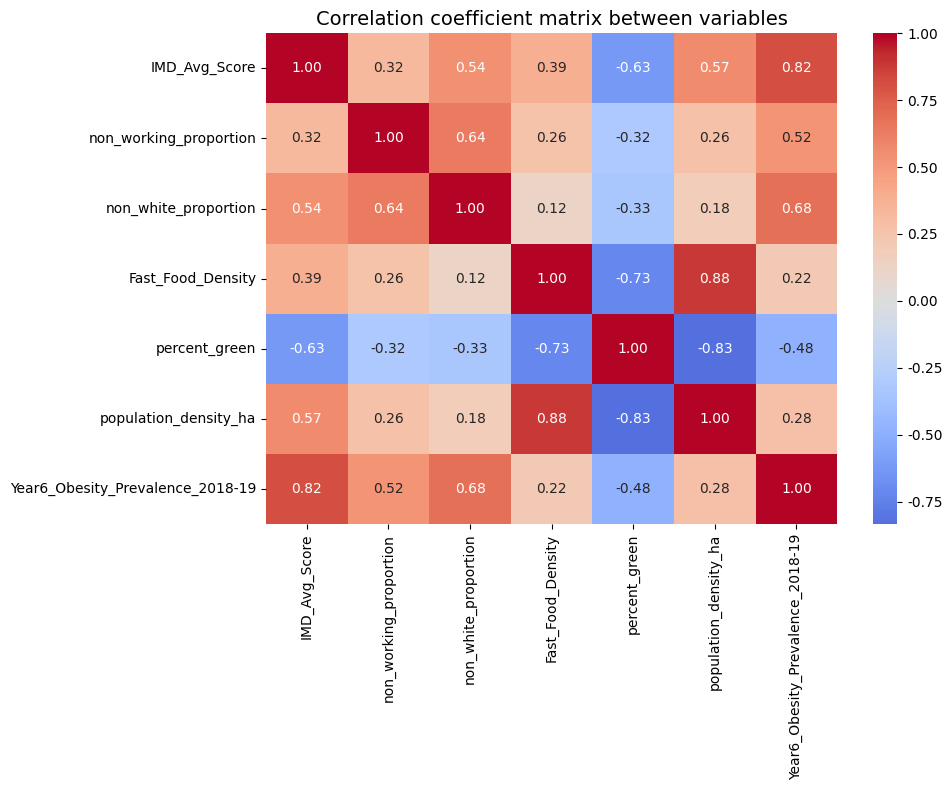

In [33]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation coefficient matrix between variables', fontsize=14)
plt.tight_layout()
plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

From the figure it can be seen that there is a certain degree of covariance in the independent variables, so after the establishment of the os it is necessary to carry out the calculation of the VIF (Variance Inflation Factor)

OLS regression analysis

In [34]:
# Add constant term
X_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_const).fit()

# Display model results
print("\nOLS Regression Results:")
print(model.summary())


OLS Regression Results:
                                   OLS Regression Results                                   
Dep. Variable:     Year6_Obesity_Prevalence_2018-19   R-squared:                       0.857
Model:                                          OLS   Adj. R-squared:                  0.823
Method:                               Least Squares   F-statistic:                     25.06
Date:                              Mon, 28 Apr 2025   Prob (F-statistic):           1.96e-09
Time:                                      14:03:10   Log-Likelihood:                -56.009
No. Observations:                                32   AIC:                             126.0
Df Residuals:                                    25   BIC:                             136.3
Df Model:                                         6                                         
Covariance Type:                          nonrobust                                         
                             coef    std err 

The regression model explained 85.7% of the variation in obesity rates, with a very good model fit and good residual independence, but with some multicollinearity pitfalls, and the strongest predictor was poverty level (IMD_Avg_Score), which was highly significant.

Multi-collinearity check - VIF value

In [35]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance inflation factor (VIF) analysis:")
print(vif_data.round(2))
print("\nnote: VIF > 10 Indicates severe multicollinearity")


Variance inflation factor (VIF) analysis:
                 Variable    VIF
1  non_working_proportion  54.53
2    non_white_proportion  33.15
0           IMD_Avg_Score  31.13
5   population_density_ha  30.86
4           percent_green  13.94
3       Fast_Food_Density  11.08

note: VIF > 10 Indicates severe multicollinearity


Visualisation VIF

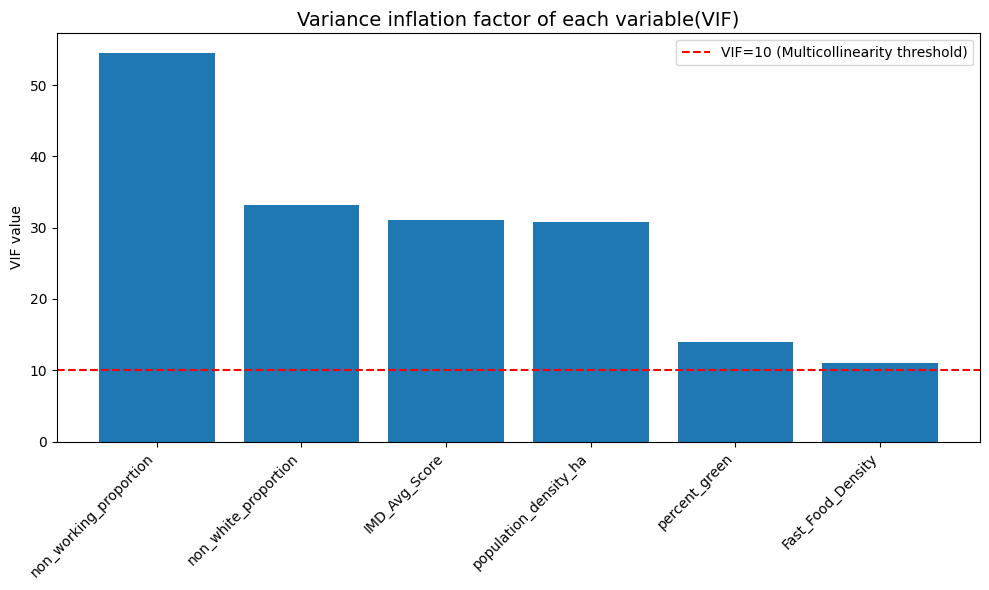

In [36]:
plt.figure(figsize=(10, 6))
bars = plt.bar(vif_data['Variable'], vif_data['VIF'])
plt.axhline(y=10, color='r', linestyle='--', label='VIF=10 (Multicollinearity threshold)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('VIF value')
plt.title('Variance inflation factor of each variable(VIF)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('outputs/vif_plot.png', dpi=300, bbox_inches='tight')
plt.show()

Severe VIF-indicated multicollinearity did not prompt variable removal because IMD_Avg_Score, non-white proportion and percent green space were theoretically essential; collinearity was recognised to inflate standard errors but not distort R² or coefficient signs. To gauge robustness under this collinearity, ridge regression was later applied to stabilise the coefficients.

Model Diagnostics（Residual Analysis）

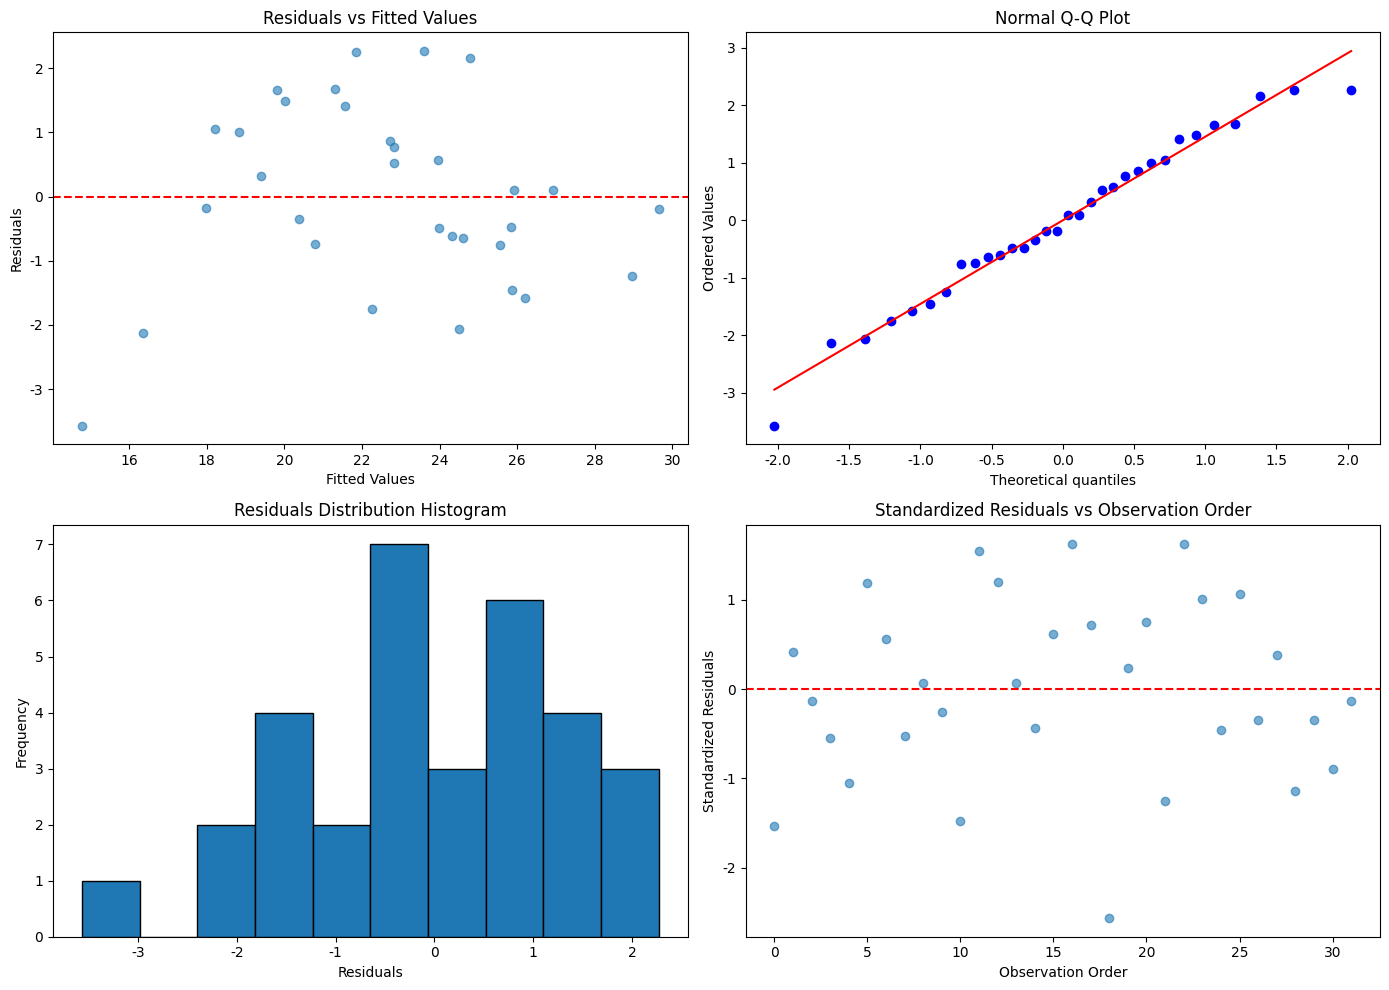

In [37]:
residuals = model.resid
fitted = model.fittedvalues

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Fitted
axes[0, 0].scatter(fitted, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values')
# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')
# Residual Histogram
axes[1, 0].hist(residuals, bins=10, edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Residuals Distribution Histogram')
# Standardized Residuals vs Observation Order
standardized_resid = residuals / np.std(residuals)
axes[1, 1].scatter(range(len(standardized_resid)), standardized_resid, alpha=0.6)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Observation Order')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Standardized Residuals vs Observation Order')

plt.tight_layout()
plt.savefig('outputs/ols_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()

The residual diagnostic plots demonstrated no substantial violations of the fundamental OLS assumptions, suggesting that linearity, normality of residuals, homoscedasticity, and independence were sufficiently upheld.

Standard errors are inflated due to multicollinearity, but all major factors are retained for interpretation to maintain theoretical integrity.

In [38]:
# OLS model fit summary
print("\n5. Model Fit Summary:")
summary_results = {
    'Metric': ['R²', 'Adjusted R²', 'F-statistic', 'F-statistic p-value', 'AIC', 'BIC', 'Number of Observations'],
    'Value': [f"{model.rsquared:.3f}", f"{model.rsquared_adj:.3f}",
              f"{model.fvalue:.2f}", f"{model.f_pvalue:.2e}",
              f"{model.aic:.1f}", f"{model.bic:.1f}", f"{model.nobs:.0f}"]
}
summary_df = pd.DataFrame(summary_results)
print(summary_df.to_string(index=False))


5. Model Fit Summary:
                Metric    Value
                    R²    0.857
           Adjusted R²    0.823
           F-statistic    25.06
   F-statistic p-value 1.96e-09
                   AIC    126.0
                   BIC    136.3
Number of Observations       32


### Ridge Regression

Using ridge regression as a complementary validation tool for OLS.

Data preparation and standardisation, using the same data as OLS.

In [39]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

Display of data before and after standardisation.

In [40]:
print("1. Description of data before standardisation:")
print(X.describe().round(2))
print("\nDescription of data after standardisation:")
print(X_scaled.describe().round(2))

1. Description of data before standardisation:
       IMD_Avg_Score  non_working_proportion  non_white_proportion  \
count          32.00                   32.00                 32.00   
mean           21.50                   53.92                 44.88   
std             6.05                    9.63                 12.79   
min             9.43                   36.88                 19.50   
25%            16.53                   46.32                 36.67   
50%            21.90                   53.47                 44.90   
75%            25.79                   60.86                 52.62   
max            32.77                   70.58                 69.20   

       Fast_Food_Density  percent_green  population_density_ha  
count              32.00          32.00                  32.00  
mean                3.93          44.80                  77.81  
std                 3.66          11.01                  41.81  
min                 0.30          25.38                  22.00

Use cross-validation to select the best alpha

In [41]:
alphas = np.logspace(-3, 3, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_scaled, y)
print(f"\n2. Best alpha for cross-validated selection: {ridge_cv.alpha_:.4f}")


2. Best alpha for cross-validated selection: 8.6975


Fitting the Ridge model using the best alpha

In [42]:
ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_best.fit(X_scaled, y)

Ridge(alpha=np.float64(8.697490026177835))

The regularisation strength is determined (α = 8.6975) and some penalty is needed to shrink the coefficients.

Generate a table of coefficient comparisons (OLS vs Ridge) to convert the ridge regression coefficients back to the original scale for comparison.

In [43]:
ridge_coef_original = ridge_best.coef_ / scaler.scale_
coef_comparison = pd.DataFrame({
    'Variable': X.columns,
    'OLS_Coefficient': model.params[1:].values,
    'Ridge_Coefficient': ridge_coef_original
})

print("\n3. Comparison of OLS and ridge regression coefficients:")
print(coef_comparison.round(4))


3. Comparison of OLS and ridge regression coefficients:
                 Variable  OLS_Coefficient  Ridge_Coefficient
0           IMD_Avg_Score           0.5327             0.3204
1  non_working_proportion           0.0950             0.0681
2    non_white_proportion           0.0232             0.0645
3       Fast_Food_Density           0.3174            -0.0067
4           percent_green          -0.0844            -0.0421
5   population_density_ha          -0.0692            -0.0141


Checking directional consistency

In [44]:
coef_comparison['Direction_Consistent'] = np.sign(coef_comparison['OLS_Coefficient']) == np.sign(coef_comparison['Ridge_Coefficient'])
direction_consistency_rate = coef_comparison['Direction_Consistent'].mean() * 100

print("\n4. Coefficient Direction Consistency Analysis:")
print(f"Number of variables with consistent direction: {coef_comparison['Direction_Consistent'].sum()}/{len(coef_comparison)}")
print(f"Direction consistency rate: {direction_consistency_rate:.1f}%")


4. Coefficient Direction Consistency Analysis:
Number of variables with consistent direction: 5/6
Direction consistency rate: 83.3%


Cross-validation R² evaluation

In [45]:
cv_scores = cross_val_score(ridge_best, X_scaled, y, cv=5, scoring='r2')
cv_r2_mean = cv_scores.mean()
cv_r2_std = cv_scores.std()

print(f"\n5. Cross-Validation Results:")
print(f"Mean R²: {cv_r2_mean:.4f} (+/- {cv_r2_std * 2:.4f})")


5. Cross-Validation Results:
Mean R²: 0.5243 (+/- 0.3432)


Calculation of ridge regression model performance metrics

In [46]:
y_pred_ridge = ridge_best.predict(X_scaled)
ridge_r2 = r2_score(y, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y, y_pred_ridge))

In [47]:
summary_results = pd.DataFrame({
    'Metric': ['Best Alpha', 'R²', 'RMSE', 'CV Mean R²', 'Direction Consistency (%)'],
    'Value': [
        f"{ridge_cv.alpha_:.4f}",
        f"{ridge_r2:.4f}",
        f"{ridge_rmse:.4f}",
        f"{cv_r2_mean:.4f}",
        f"{direction_consistency_rate:.1f}"
    ]
})

print("\n6. Summary of results from ridge regression analysis:")
print(summary_results.to_string(index=False))


6. Summary of results from ridge regression analysis:
                   Metric  Value
               Best Alpha 8.6975
                       R² 0.7845
                     RMSE 1.7125
               CV Mean R² 0.5243
Direction Consistency (%)   83.3


### Random Forest

Random forests were used as a validation variable importance to assist the OLS analysis.

Ensure that arrays are used properly.

In [48]:
if not hasattr(y, 'shape') or (hasattr(y, 'shape') and len(y.shape) == 0) or (hasattr(y, 'shape') and y.shape[0] == 1):
    print("Detected an issue with the format of y. Re-extracting data...")
    # Redefine variables
    X_cols = ['IMD_Avg_Score', 'non_working_proportion', 'non_white_proportion',
              'Fast_Food_Density', 'percent_green', 'population_density_ha']
    y_col = 'Year6_Obesity_Prevalence_2018-19'

    # Re-extract X and y
    X = regression_data[X_cols]
    y = regression_data[y_col]
else:
    print("Using the existing X and y variables.")

# Verify data
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")

Using the existing X and y variables.
Shape of X: (32, 6)
Shape of y: (32,)
Number of samples: 32
Number of features: 6


A Random Forest regressor with 500 trees was constructed to assess the relative importance of explanatory variables.

In [49]:
rf_model = RandomForestRegressor(
    n_estimators=500,
    random_state=0,
    n_jobs=-1
)

fit the model

In [50]:
rf_model.fit(X, y)

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=0)

Calculate and rank feature importance

In [51]:
feature_importance = rf_model.feature_importances_
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nRanking of feature importance:")
print(importance_df.round(4))


Ranking of feature importance:
                 Variable  Importance
0           IMD_Avg_Score      0.6163
2    non_white_proportion      0.1968
1  non_working_proportion      0.0940
3       Fast_Food_Density      0.0426
4           percent_green      0.0289
5   population_density_ha      0.0215


Visualising the importance of features

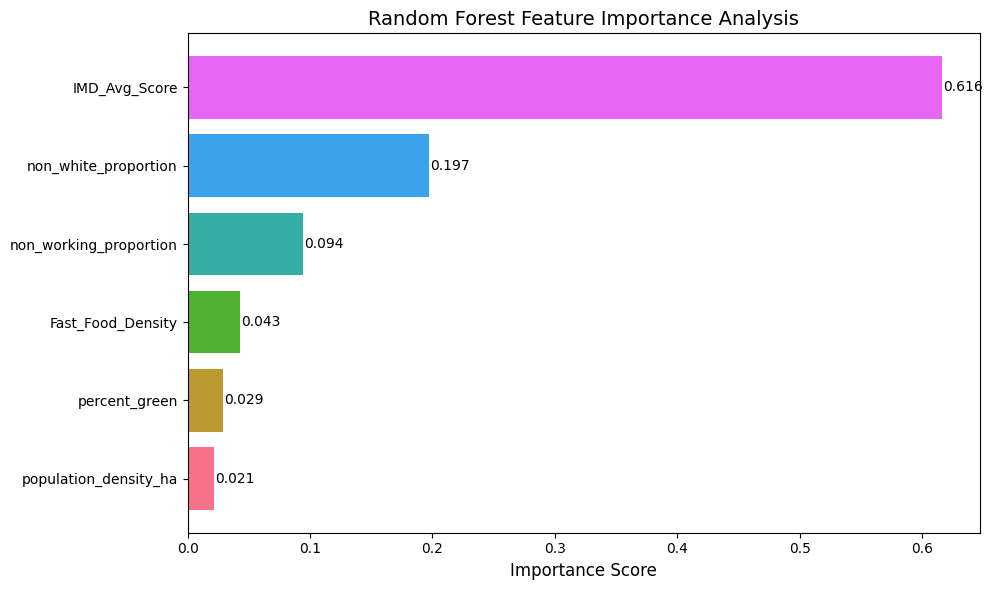

In [52]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(importance_df))

bars = plt.barh(importance_df['Variable'][::-1],
                importance_df['Importance'][::-1],
                color=colors)

plt.xlabel('Importance Score', fontsize=12)
plt.title('Random Forest Feature Importance Analysis', fontsize=14)
plt.tight_layout()

# Adding numeric labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

plt.savefig('outputs/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Cross-validation to assess model stability

In [53]:
print("\n5-Fold Cross-Validation Results:")
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print(f"Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Individual folds R²: {[round(score, 4) for score in cv_scores]}")


5-Fold Cross-Validation Results:
Mean R²: 0.3333 (+/- 0.5458)
Individual folds R²: [np.float64(0.5769), np.float64(0.3792), np.float64(0.6416), np.float64(-0.1022), np.float64(0.1711)]


The average R² is only 0.333, and the model's performance fluctuates widely across folds (high standard deviation, ±0.54)

Computational model performance metrics

In [54]:
y_pred_rf = rf_model.predict(X)
rf_r2 = r2_score(y, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y, y_pred_rf))

In [55]:
summary_results = pd.DataFrame({
    'Metric': ['R²', 'RMSE', 'CV Mean R²', 'Top 3 Important Variables'],
    'Value': [
        f"{rf_r2:.4f}",
        f"{rf_rmse:.4f}",
        f"{cv_scores.mean():.4f}",
        ', '.join(importance_df['Variable'].head(3).values)
    ]
})

print("\nSummary of the results of the random forest analysis:")
print(summary_results.to_string(index=False))


Summary of the results of the random forest analysis:
                   Metric                                                       Value
                       R²                                                      0.9615
                     RMSE                                                      0.7241
               CV Mean R²                                                      0.3333
Top 3 Important Variables IMD_Avg_Score, non_white_proportion, non_working_proportion


In [56]:
print("\nKey Findings:")
print(f"The most important variable is: {importance_df.iloc[0]['Variable']} (Importance: {importance_df.iloc[0]['Importance']:.3f})")
print(f"The top three variables together account for {importance_df['Importance'].head(3).sum():.1%} of the total importance.")


Key Findings:
The most important variable is: IMD_Avg_Score (Importance: 0.616)
The top three variables together account for 90.7% of the total importance.


## Results

[[ go back to the top ]](#Table-of-contents)

Moran’s I reveals significant positive spatial autocorrelation (I ≈ 0.30, p < 0.01), showing that high Year-6 obesity areas tend to cluster.
OLS regression accounts for 86 % of variance (adj. R² = 0.823). Deprivation (IMD_Avg_Score, β ≈ 0.53, p < 0.001) is the strongest predictor, with smaller contributions from unemployment and population density; greener areas show a weak, non-significant protective trend. Yet extreme VIFs (> 30) signal serious multicollinearity.

Ridge regression (best α ≈ 8.7) shrinks coefficients and stabilises the model, retaining coefficient direction for 5 / 6 variables. Fit remains respectable (R² = 0.78; mean CV R² = 0.52) but is lower than OLS, reflecting its penalty for collinearity.

Random-forest analysis echoes these findings: IMD_Avg_Score captures 61.6 % of total importance, ahead of ethnic composition and unemployment. Although in-sample R² is very high (0.96), five-fold CV R² averages only 0.33, indicating over-fitting.

## Limitations to the model

[[ go back to the top ]](#Table-of-contents)

The models applied in this study still have several limitations must be noted. First, the small sample size (32 boroughs) limited statistical power and increased the risk of overfitting, particularly in the Random Forest analysis where the training R² was much higher than the cross-validation R². Second, multicollinearity among predictors, as shown by high VIF values in the OLS regression, despite mitigation through Ridge regression, may obscure true variable effects. Third, although spatial autocorrelation was detected, non-spatial models were applied, potentially biasing estimates. Finally, borough-level aggregation may mask intra-borough variations. Overall, while the findings are robust within the constraints of the available data and methods, future studies should consider larger sample sizes, spatial regression techniques, and more detailed data sources to further enhance model reliability and interpretation.

## Conclusion

Our analysis revealed spatial patterns of childhood obesity across London boroughs, confirmed by significant spatial autocorrelation (Moran's I = 0.2981, p = 0.0060), highlighting the need for spatial considerations. Multiple linear regression showed that poverty level (IMD_Avg_Score) had the strongest association with obesity rates, followed by workless household proportion and population density. Ridge regression stabilized estimates despite multicollinearity, and Random Forest further confirmed deprivation as the key predictor, though it showed overfitting due to the small sample size (32 boroughs). Environmental factors like fast food density and green space coverage were weakly associated across all models. Despite offering valuable insights, the study faced limitations, including small sample size, multicollinearity, use of non-spatial models, and borough-level aggregation. Future research should apply spatial regression techniques and finer-scale data to capture local variations more accurately. Addressing socioeconomic disparities remains essential to tackling spatial inequalities in childhood obesity.



## References

[[ go back to the top ]](#Table-of-contents)

Chalkias, C. et al. (2013) Geographical heterogeneity of the relationship between childhood obesity and socio-environmental status: Empirical evidence from Athens, Greece, online available at: [here](https://www-sciencedirect-com.libproxy.ucl.ac.uk/science/article/pii/S0143622812001087), retrieved in February, 2020.

Jia, P. et al. (2017) Applications of geographic information systems (GIS) data and methods in obesity‐related research, online available at: [here](https://onlinelibrary-wiley-com.libproxy.ucl.ac.uk/doi/full/10.1111/obr.12495), retrieved on 06 February 2017.

Sun, Y. et al. (2020) Spatial Patterns of Childhood Obesity Prevalence in Relation to Socioeconomic Factors across England. ISPRS international journal of geo-information, online available at: [here](https://www.proquest.com/docview/2548594879?accountid=14511&parentSessionId=4k%2FsRnzzFlnp0aaf83RYilg4tlPY6KZAW6e82FHTsWw%3D&parentSessionId=xGTicb178OyoIAqtHv09RgJ4aRusjXLJDuRM812E5ms%3D&pq-origsite=primo&sourcetype=Scholarly%20Journals), retrieved on 11 October 2020.



In [ ]:
print(f"Notebook 总运行时间: {time.time() - start_time:.2f} 秒")

In [60]:
import nbformat

# 读取当前Notebook
from google.colab import drive
drive.mount('/content/drive')  # 如果你的.ipynb在Google Drive，挂载一下
path = '/content/drive/MyDrive/Colab Notebooks/Template_submission_CASA0006.ipynb'  # 改成你的.ipynb路径

with open(path, 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

markdown_text = ""
for cell in nb.cells:
    if cell.cell_type == 'markdown':
        markdown_text += cell.source + " "

word_count = len(markdown_text.split())
char_count = len(markdown_text.replace(" ", ""))  # 不算空格的字符数

print(f"Markdown总字数（按空格分隔单词）: {word_count}")
print(f"Markdown总字符数（不含空格）: {char_count}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Markdown总字数（按空格分隔单词）: 2419
Markdown总字符数（不含空格）: 16156
